In [ ]:
import requests
import markdown
import re
from bs4 import BeautifulSoup
from typing import List, Dict
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize


In [26]:
class ArticleDownloader:
    """Класс для скачивания статей из документации."""
    
    def __init__(self):
        self.md_list = [
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/collections.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/explore.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/filtering.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/hybrid-queries.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/indexing.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/optimizer.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/payload.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/search.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/points.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/snapshots.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/storage.md',
            'https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/concepts/vectors.md'
        ]
    
    def download_article(self, url: str) -> str:
        """Скачивает статью по указанному URL."""
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    
    def get_all_articles(self) -> List[Dict[str, str]]:
        """Скачивает все статьи из списка и возвращает их с метаданными."""
        articles = []
        for url in self.md_list:
            content = self.download_article(url)
            name = url.split('concepts/')[1].split('.md')[0]
            articles.append({
                'name': name,
                'url': url,
                'content': content
            })
        return articles


class TextPreprocessor:
    """Класс для предобработки текстов статей."""
    
    def extract_subheadings_and_content(self, markdown_text: str) -> List[Dict[str, str]]:
        """Разбивает markdown-документ на части по подзаголовкам (##).
        
        Returns:
            List[Dict[str, str]]: Список словарей с ключами 'title' и 'content'
        """
        # Удаляем YAML-фронтматтер (metadata в начале файла между ---)
        markdown_text = re.sub(r'^---\n[\s\S]*?\n---\n', '', markdown_text)
        
        # Удаляем основной заголовок статьи (# Title) и следующие за ним пустые строки
        markdown_text = re.sub(r'^\s*#\s+[^\n]+\n+', '', markdown_text)
        
        # Обрабатываем код-сниппеты
        markdown_with_code = self._replace_code_snippets(markdown_text)
        
        # Разделяем текст по подзаголовкам (##)
        # Ищем все строки, начинающиеся с ## (возможны пробелы перед ##)
        pattern = r'(?:^|\n)(\s*##\s+(.+)(?:\n|$))'
        
        # Находим все подзаголовки с их позициями
        matches = list(re.finditer(pattern, markdown_with_code))
        
        result = []
        
        # Если не нашли подзаголовков, возвращаем весь текст как один элемент
        if not matches:
            # Проверяем, есть ли заголовок первого уровня (#)
            title_match = re.search(r'(?:^|\n)(\s*#\s+(.+)(?:\n|$))', markdown_with_code)
            title = title_match.group(2).strip() if title_match else "No Title"
            
            # Удаляем заголовок из содержимого
            content = re.sub(r'^\s*#\s+[^\n]+\n+', '', markdown_with_code).strip()
            
            result.append({
                'title': title,
                'content': content
            })
            return result
        
        # Обрабатываем текст до первого подзаголовка
        if matches[0].start() > 0:
            intro_text = markdown_with_code[:matches[0].start()].strip()
            # Проверяем, есть ли заголовок первого уровня (#)
            title_match = re.search(r'(?:^|\n)(\s*#\s+(.+)(?:\n|$))', intro_text)
            
            if title_match:
                title = title_match.group(2).strip()
                # Удаляем заголовок из содержимого
                intro_text = re.sub(r'^\s*#\s+[^\n]+\n+', '', intro_text).strip()
            else:
                title = "Introduction"
            
            if intro_text:
                result.append({
                    'title': title,
                    'content': intro_text
                })
        
        # Обрабатываем содержимое между подзаголовками
        for i in range(len(matches)):
            title = matches[i].group(2).strip()
            
            # Определяем начало и конец содержимого для текущего подзаголовка
            start_pos = matches[i].end()
            end_pos = matches[i+1].start() if i < len(matches) - 1 else len(markdown_with_code)
            
            # Получаем содержимое без заголовка и очищаем от начальных пробелов и переносов строк
            content = markdown_with_code[start_pos:end_pos].strip()
            
            result.append({
                'title': title,
                'content': content
            })
        
        return result
    
    def split_large_sections(self, sections: List[Dict[str, str]], max_chars: int = 5000) -> List[Dict[str, str]]:
        """Разбивает большие секции по заголовкам третьего уровня (###).
        
        Args:
            sections: Список словарей с ключами 'title' и 'content'
            max_chars: Максимальная длина содержимого раздела
            
        Returns:
            List[Dict[str, str]]: Расширенный список разделов
        """
        result = []
        
        for section in sections:
            # Если секция меньше лимита, оставляем как есть
            if len(section['content']) <= max_chars:
                result.append(section)
                continue
                
            # Ищем подзаголовки третьего уровня
            pattern = r'(?:^|\n)(\s*###\s+(.+)(?:\n|$))'
            subsection_matches = list(re.finditer(pattern, section['content']))
            
            # Если нет подзаголовков, оставляем как есть
            if not subsection_matches:
                result.append(section)
                continue
                
            # Обрабатываем текст до первого подзаголовка
            if subsection_matches[0].start() > 0:
                intro_content = section['content'][:subsection_matches[0].start()].strip()
                if intro_content:
                    result.append({
                        'title': section['title'],
                        'content': intro_content,
                        'is_subsection': False
                    })
            
            # Обрабатываем содержимое между подзаголовками
            for j in range(len(subsection_matches)):
                subsection_title = subsection_matches[j].group(2).strip()
                
                # Определяем начало и конец содержимого для текущего подзаголовка
                start_pos = subsection_matches[j].end()
                end_pos = subsection_matches[j+1].start() if j < len(subsection_matches) - 1 else len(section['content'])
                
                # Получаем содержимое без заголовка
                subsection_content = section['content'][start_pos:end_pos].strip()
                
                result.append({
                    'title': f"{section['title']} - {j+1}. {subsection_title}",
                    'content': subsection_content,
                    'is_subsection': True,
                    'parent_title': section['title'],
                    'subsection_num': j+1
                })
        
        return result
    
    def _replace_code_snippets(self, markdown_text: str) -> str:
        """Заменяет ссылки на код-сниппеты реальным содержимым."""
        pattern = r'{{< code-snippet path="([^"]+)" >}}'
        
        def replace_snippet(match):
            path = match.group(1)
            # Проверяем, заканчивается ли путь на .md
            if not path.endswith('.md'):
                path = f"{path}/python.md"  # Добавляем python.md, если его нет
                
            full_url = f"https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content{path}"
            
            try:
                response = requests.get(full_url)
                response.raise_for_status()
                code = response.text
                # Удаляем возможный фронтматтер из кода
                code = re.sub(r'^---\n[\s\S]*?\n---\n', '', code)
                return f"```python\n{code}\n```"
            except Exception as e:
                print(f"Ошибка при получении кода: {e} (URL: {full_url})")
                # Пробуем альтернативный URL для python.md
                if not path.endswith('python.md'):
                    alt_path = path.rstrip('/') + '/python.md'
                    alt_url = f"https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content{alt_path}"
                    try:
                        alt_response = requests.get(alt_url)
                        alt_response.raise_for_status()
                        code = alt_response.text
                        # Удаляем возможный фронтматтер из кода
                        code = re.sub(r'^---\n[\s\S]*?\n---\n', '', code)
                        return f"```python\n{code}\n```"
                    except Exception as alt_e:
                        print(f"Ошибка при получении кода по альтернативному URL: {alt_e} (URL: {alt_url})")
                
                # Если все попытки не удались
                return f"```\nНе удалось получить код: {full_url}\n```"
        
        return re.sub(pattern, replace_snippet, markdown_text)
    
    def preprocess_markdown(self, markdown_text: str) -> str:
        """Конвертирует markdown в обычный текст."""
        html_content = markdown.markdown(markdown_text)
        soup = BeautifulSoup(html_content, features="html.parser")
        return soup.get_text()
    
    def remove_code_blocks(self, markdown_text: str) -> str:
        """Удаляет блоки кода из markdown-документа.
        
        Обрабатывает как блоки кода в формате ```language ... ``` или в формате с отступами.
        """
        # Удаление блоков кода в формате ```code```
        text_without_fenced_code = re.sub(
            r'```[\s\S]*?```', 
            ' ', 
            markdown_text
        )
        
        # Удаление однострочных блоков кода в формате `code`
        text_without_inline_code = re.sub(
            r'`.*?`', 
            ' ', 
            text_without_fenced_code
        )
        
        # Удаление блоков кода с отступами (строки, начинающиеся с 4+ пробелов или табуляции)
        lines = text_without_inline_code.split('\n')
        in_code_block = False
        result_lines = []
        
        for line in lines:
            if re.match(r'^( {4,}|\t)', line):
                # Это строка кода с отступом
                if not in_code_block:
                    in_code_block = True
            else:
                # Это не строка кода
                if in_code_block:
                    in_code_block = False
                result_lines.append(line)
        
        # Объединяем строки обратно в текст
        cleaned_text = '\n'.join(result_lines)
        
        # Удаляем возможные оставшиеся пустые участки после удаления кода
        cleaned_text = re.sub(r'\n\s*\n\s*\n', '\n\n', cleaned_text)
        
        return cleaned_text
    
    def split_into_paragraphs(self, text: str, max_characters: int = 1500, 
                             new_after_n_chars: int = 1000, overlap: int = 0) -> List[str]:
        """Разделяет текст на параграфы с учетом заданных ограничений."""
        # Разделяем на смысловые элементы
        raw_paragraphs = [p.strip() for p in re.split(r'\n\s*\n', text) if p.strip()]
        
        paragraphs = []
        current_chunk = ""
        
        for p in raw_paragraphs:
            # Нормализуем пробелы
            cleaned_p = re.sub(r'\s+', ' ', p).strip()
            
            # Пропускаем слишком короткие фрагменты
            if len(cleaned_p.split()) < 5:
                continue
                
            # Определяем, является ли текущий параграф заголовком
            is_title = len(cleaned_p.split()) < 10 and not cleaned_p.endswith(('.', '?', '!'))
            
            # Если новый параграф - заголовок или текущий чанк станет слишком большим
            if is_title or len(current_chunk) + len(cleaned_p) > new_after_n_chars:
                # Сохраняем предыдущий чанк, если он не пустой
                if current_chunk:
                    paragraphs.append(current_chunk)
                    current_chunk = ""
            
            # Если параграф слишком большой, разбиваем его на части
            if len(cleaned_p) > max_characters:
                # Разбиваем на предложения
                sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', cleaned_p)
                
                sentence_chunk = ""
                for sentence in sentences:
                    if len(sentence_chunk) + len(sentence) > max_characters:
                        paragraphs.append(sentence_chunk)
                        # Добавляем перекрытие, если задано
                        if overlap > 0:
                            words = sentence_chunk.split()
                            overlap_text = ' '.join(words[-min(len(words), overlap//5):])
                            sentence_chunk = overlap_text + " " + sentence
                        else:
                            sentence_chunk = sentence
                    else:
                        sentence_chunk = (sentence_chunk + " " + sentence).strip() if sentence_chunk else sentence
                
                if sentence_chunk:
                    paragraphs.append(sentence_chunk)
            else:
                # Добавляем параграф к текущему чанку
                current_chunk = (current_chunk + "\n\n" + cleaned_p).strip() if current_chunk else cleaned_p
                
                # Если чанк превысил максимальный размер, сохраняем его
                if len(current_chunk) > max_characters:
                    paragraphs.append(current_chunk)
                    current_chunk = ""
        
        # Добавляем последний чанк, если он не пустой
        if current_chunk:
            paragraphs.append(current_chunk)
        
        return paragraphs
    
    def extract_text_from_md(self, markdown_text: str, max_characters: int = 1500, 
                            new_after_n_chars: int = 1000, overlap: int = 0) -> List[str]:
        """Объединяет предобработку markdown и разделение на параграфы."""
        # Получаем текст, разбитый по подзаголовкам, с замененными код-сниппетами
        sections = self.extract_subheadings_and_content(markdown_text)
        
        result = []
        for section in sections:
            # Превращаем в обычный текст
            plain_text = self.preprocess_markdown(section['content'])
            # Разбиваем на параграфы
            paragraphs = self.split_into_paragraphs(plain_text, max_characters, new_after_n_chars, overlap)
            
            # Добавляем каждый параграф с метаданными
            for p in paragraphs:
                result.append(p)
        
        return result
    
    def filter_paragraphs(self, paragraphs: List[str], name: str) -> List[str]:
        """Фильтрует параграфы, удаляя служебную информацию."""
        if name == 'collections':
            return [p for p in paragraphs if '/ Collections' not in p]
        else:
            return [p for p in paragraphs if f'/{name}' not in p]
    
    def create_dataset_df(self, articles: List[Dict[str, str]], max_section_length: int = 5000) -> pd.DataFrame:
        """Создает DataFrame из статей с разбивкой по подзаголовкам.
        
        Дополнительно разбивает секции более max_section_length символов по подзаголовкам ###.
        
        Args:
            articles: Список словарей с ключами 'name', 'url', 'content'
            max_section_length: Максимальная длина раздела перед разбивкой
            
        Returns:
            pd.DataFrame: DataFrame с колонками page_name, section_title, section_content
        """
        dataset = []
        
        for article in articles:
            page_name = article['name']
            # Сначала получаем разделы по ##
            sections = self.extract_subheadings_and_content(article['content'])
            
            # Теперь проходим по разделам и разбиваем их, если они слишком большие
            all_sections = []
            for section in sections:
                if len(section['content']) > max_section_length:
                    # Ищем подзаголовки третьего уровня
                    pattern = r'(?:^|\n)(\s*###\s+(.+)(?:\n|$))'
                    subsection_matches = list(re.finditer(pattern, section['content']))
                    
                    # Если есть подзаголовки, разбиваем по ним
                    if subsection_matches:
                        # Добавляем текст до первого подзаголовка, если он есть
                        if subsection_matches[0].start() > 0:
                            intro_content = section['content'][:subsection_matches[0].start()].strip()
                            if intro_content:
                                all_sections.append({
                                    'title': section['title'],
                                    'content': intro_content
                                })
                        
                        # Обрабатываем подзаголовки
                        for j in range(len(subsection_matches)):
                            subsection_title = subsection_matches[j].group(2).strip()
                            
                            # Определяем содержимое подраздела
                            start_pos = subsection_matches[j].end()
                            end_pos = subsection_matches[j+1].start() if j < len(subsection_matches) - 1 else len(section['content'])
                            
                            subsection_content = section['content'][start_pos:end_pos].strip()
                            
                            all_sections.append({
                                'title': f"{section['title']} - {j+1}. {subsection_title}",
                                'content': subsection_content
                            })
                    else:
                        # Если нет подзаголовков, оставляем как есть
                        all_sections.append(section)
                else:
                    # Если раздел не превышает максимальную длину, оставляем как есть
                    all_sections.append(section)
            
            # Добавляем все разделы в датасет
            for section in all_sections:
                dataset.append({
                    'page_name': page_name,
                    'section_title': section['title'],
                    'section_content': section['content']
                })

        # Создаем DataFrame и добавляем дополнительные колонки
        df = pd.DataFrame(dataset)
        df['len_section_content'] = df['section_content'].str.len()
        df['content_id'] = df['section_content'].factorize()[0]
        
        return df
    
    def create_dataset_csv(self, articles: List[Dict[str, str]], output_path: str, max_section_length: int = 5000) -> None:
        """Создает CSV-датасет из статей с разбивкой по подзаголовкам.
        
        Args:
            articles: Список словарей с ключами 'name', 'url', 'content'
            output_path: Путь для сохранения CSV файла
            max_section_length: Максимальная длина раздела перед разбивкой
        """
        # Получаем DataFrame с разбивкой больших секций
        df = self.create_dataset_df(articles, max_section_length)
        
        # Сохраняем в CSV
        df.to_csv(output_path, index=False, encoding='utf-8')
        print(f"Датасет успешно сохранен в {output_path}")

In [27]:
downloader = ArticleDownloader()
preprocessor = TextPreprocessor()

# Скачиваем все статьи
articles = downloader.get_all_articles()

# Создаем DataFrame с датасетом
df = preprocessor.create_dataset_df(articles)

df.head()

Ошибка при получении кода: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/headless/snippets/update-collection/vectors-to-disk-default/python.md (URL: https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/headless/snippets/update-collection/vectors-to-disk-default//python.md)
Ошибка при получении кода: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/headless/snippets/update-collection/vectors-to-disk-named/python.md (URL: https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/headless/snippets/update-collection/vectors-to-disk-named//python.md)
Ошибка при получении кода: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/qdrant/landing_page/master/qdrant-landing/content/documentation/headless/snippets/set-payl

,page_name,section_title,section_content,len_section_content,content_id
0,collections,Introduction,A collection is a named set of points (vectors...,1398,0
1,collections,Setting up multitenancy,**How many collections should you create?** In...,701,1
2,collections,Create a collection,```python\n```python\nfrom qdrant_client impor...,2043,2
3,collections,Create a collection - 1. Create collection fro...,*Available as of v1.0.0*\n\nIt is possible to ...,976,3
4,collections,Create a collection - 2. Collection with multi...,*Available as of v0.10.0*\n\nIt is possible to...,1458,4


In [28]:
df.to_csv('qdrant_documentation_dataset_prep.csv', index=False)

Обогатим датасет вопросами и ответами для каждого фрагмента.

In [29]:
df = pd.read_csv('qdrant_documentation_dataset.csv')
df.head()

,page_name,section_title,section_content,len_section_content,content_id,question,answer
0,collections,Introduction,A collection is a named set of points (vectors...,1398,0,What is a collection in Qdrant and what requir...,A collection in Qdrant is a named set of point...
1,collections,Introduction,A collection is a named set of points (vectors...,1398,0,What similarity metrics does Qdrant support fo...,Qdrant supports four popular types of metrics ...
2,collections,Introduction,A collection is a named set of points (vectors...,1398,0,What is the relationship between the choice of...,The choice of distance metric in Qdrant depend...
3,collections,Introduction,A collection is a named set of points (vectors...,1398,0,How does Qdrant implement Cosine similarity fo...,"For search efficiency, Qdrant implements Cosin..."
4,collections,Introduction,A collection is a named set of points (vectors...,1398,0,Can collection parameters in Qdrant be modifie...,"Yes, collection parameters in Qdrant can be ch..."


In [30]:
df.content_id.nunique()

121

In [31]:
df.page_name.nunique()

12

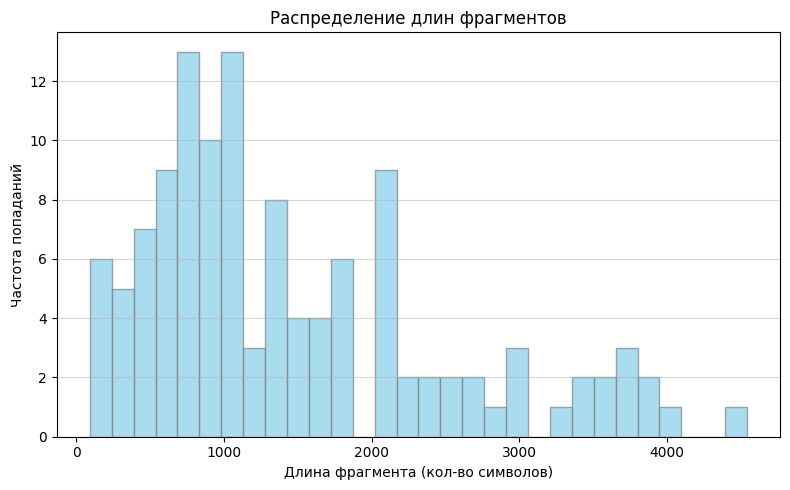

In [32]:
plt.figure(figsize=(8, 5))
plt.hist(df.groupby(['content_id','len_section_content'], as_index=False).section_title.unique().len_section_content, bins=30, color='skyblue', alpha=0.7, edgecolor='gray')
plt.title('Распределение длин фрагментов')
plt.xlabel('Длина фрагмента (кол-во символов)')
plt.ylabel('Частота попаданий')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [37]:
df['word_count'] = df['section_content'].apply(lambda x: len(x.split()))

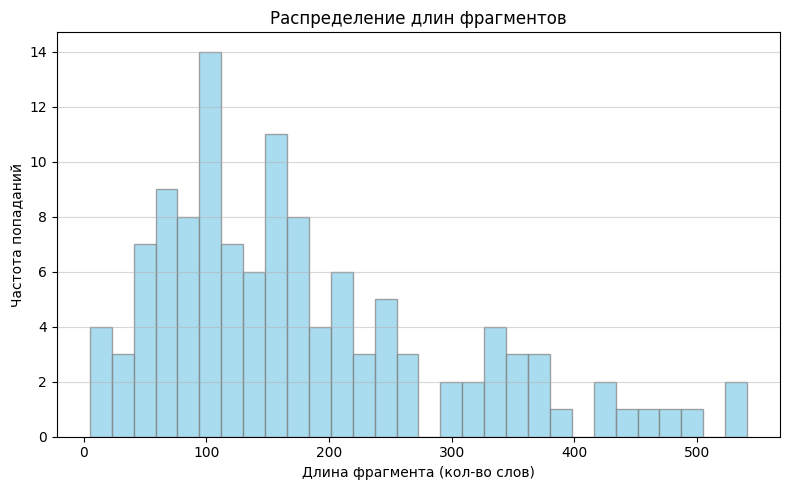

In [38]:
plt.figure(figsize=(8, 5))
plt.hist(df.groupby(['content_id','word_count'], as_index=False).section_title.unique().word_count, bins=30, color='skyblue', alpha=0.7, edgecolor='gray')
plt.title('Распределение длин фрагментов')
plt.xlabel('Длина фрагмента (кол-во слов)')
plt.ylabel('Частота попаданий')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

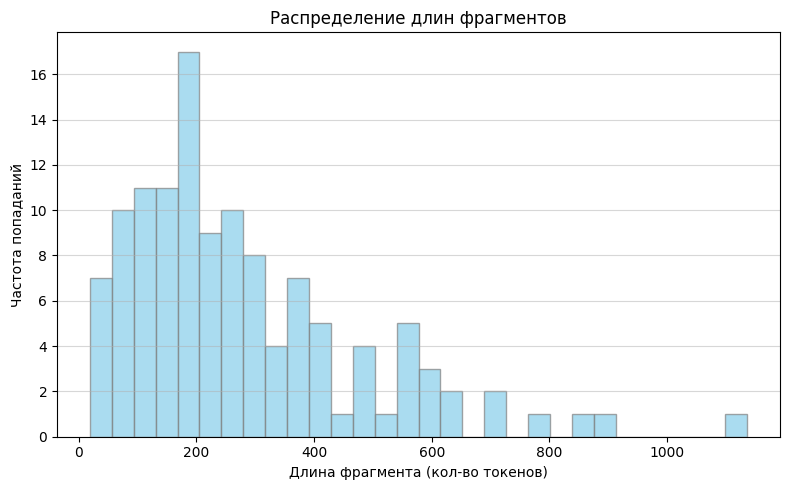

In [ ]:
df['token_count'] = df['section_content'].apply(lambda x: len(word_tokenize(x, language='english')))

plt.figure(figsize=(8, 5))
plt.hist(df.groupby(['content_id','token_count'], as_index=False).section_title.unique().token_count, bins=30, color='skyblue', alpha=0.7, edgecolor='gray')
plt.title('Распределение длин фрагментов')
plt.xlabel('Длина фрагмента (кол-во токенов)')
plt.ylabel('Частота попаданий')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


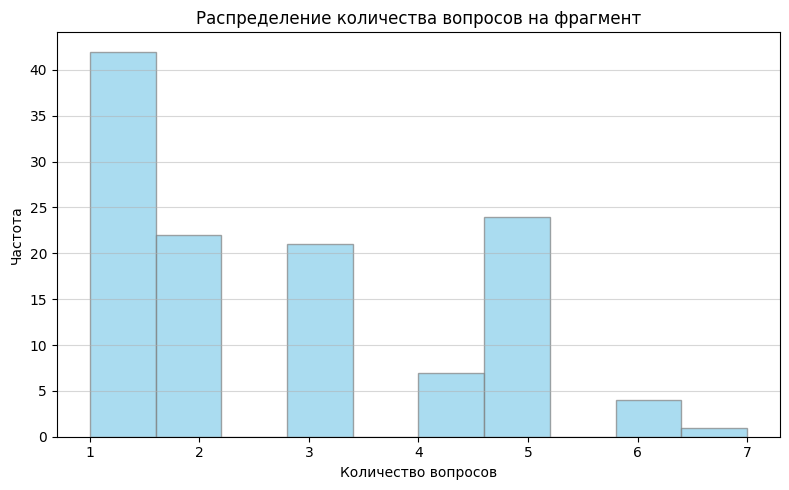

In [40]:
plt.figure(figsize=(8, 5))
plt.hist(df.groupby(['content_id'], as_index=False).question.nunique().question, color='skyblue', alpha=0.7, edgecolor='gray')
plt.title('Распределение количества вопросов на фрагмент')
plt.xlabel('Количество вопросов')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

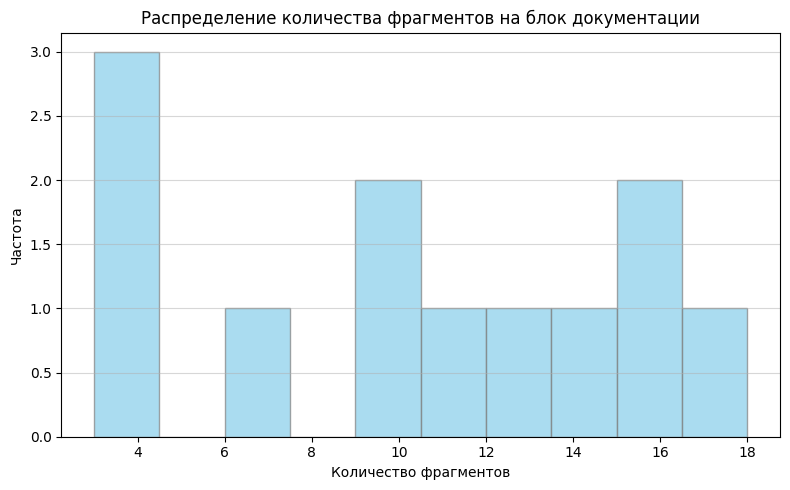

In [34]:
plt.figure(figsize=(8, 5))
plt.hist(df.groupby(['page_name'], as_index=False).section_title.nunique().section_title, color='skyblue', alpha=0.7, edgecolor='gray')
plt.title('Распределение количества фрагментов на блок документации')
plt.xlabel('Количество фрагментов')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\sekho\AppData\Local\Temp\ipykernel_2404\330151946.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


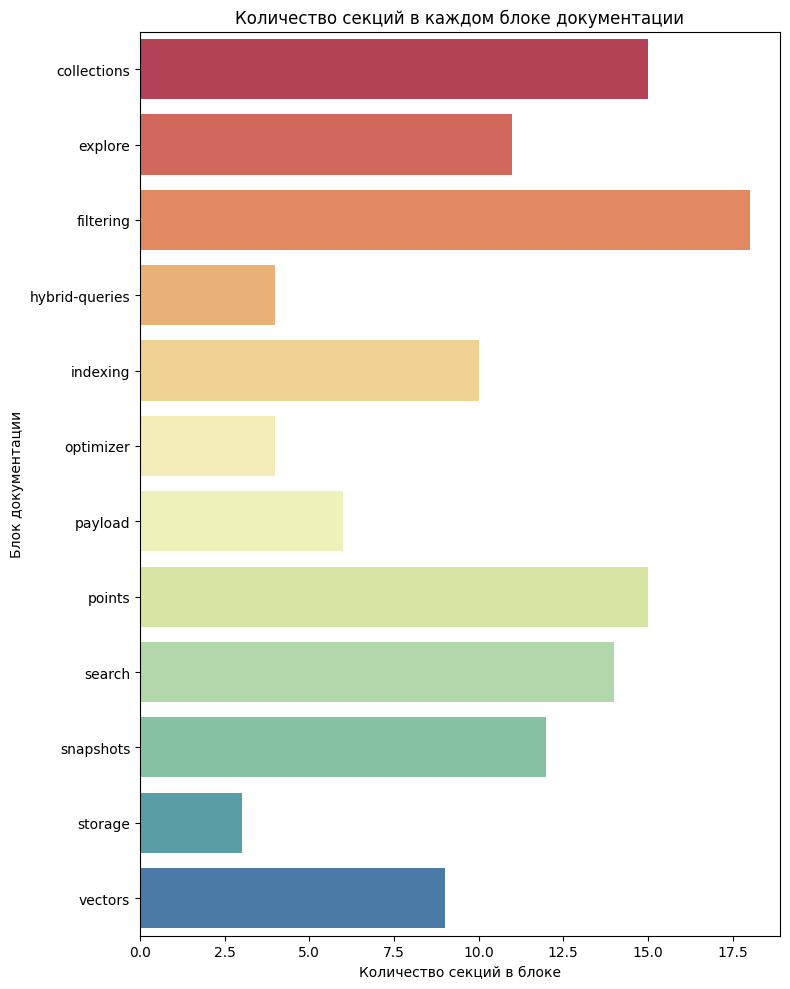

In [35]:
plt.figure(figsize=(8, 10))
sns.barplot(
    data=df.groupby(['page_name'], as_index=False).section_title.nunique(),
    y='page_name',
    x='section_title',
    palette='Spectral'
)
plt.ylabel('Блок документации')
plt.xlabel('Количество секций в блоке')
plt.title('Количество секций в каждом блоке документации')
plt.tight_layout()
plt.show()